이 자료는 위키독스 '딥 러닝을 이용한 자연어 처리 입문'의 트랜스포머 튜토리얼로 작성되었습니다.  
2021년 10월 8일에 정상 동작을 확인하였습니다.  

챗봇의 성능이 아쉽다면 모델의 크기를 조정해보세요.

링크 :  
https://wikidocs.net/31379  
https://wikidocs.net/89786

# 16-02 트랜스포머를 이용한 한국어 챗봇(Transformer Chatbot Tutorial)
---

# 챗봇 구현

앞서 구현한 트랜스포머 코드를 사용하여 일상 대화 챗봇을 구현합니다. **이번 실습은 바로 이전의 트랜스포머 실습 코드를 모두 실행하였다고 가정**하므로 이전 트랜스포머 실습을 진행 후에 이어서 진행해야 합니다.

트랜스포머 챗봇 전체 코드는 아래의 링크에 공유합니다.

* 깃허브 링크 : https://github.com/ukairia777/tensorflow-transformer

## 1. 데이터 로드하기 

In [1]:
import pandas as pd
import urllib.request
import tensorflow_datasets as tfds
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import re

챗봇 데이터를 로드하여 상위 5개의 샘플을 출력해봅시다.

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")

train_data = pd.read_csv('ChatBotData.csv')
train_data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [3]:
print('챗봇 샘플의 개수 :', len(train_data))

챗봇 샘플의 개수 : 11823


총 샘플의 개수는 11,823개입니다. 불필요한 Null 값이 있는지 확인해봅시다.

In [4]:
print(train_data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


Null 값은 별도로 존재하지 않습니다. 이번 실습에서는 토큰화를 위해 형태소 분석기를 사용하지 않고, 다른 방법인 학습 기반의 토크나이저를 사용할 것입니다. 그래서 원 데이터에서 ?, ., !와 같은 구두점을 미리 처리해두어야 하는데, 구두점들을 단순히 제거할 수도 있겠지만, 여기서는 구두점 앞에 공백. 즉, 띄어쓰기를 추가하여 다른 문자들과 구분하겠습니다.

가령, '12시 땡!' 이라는 문장이 있다면 '12시 땡 !'으로 땡과 !사이에 공백을 추가합니다. 이는 정규 표현식을 사용하여 가능합니다. 이 전처리는 질문 데이터와 답변 데이터 모두에 적용해줍니다.

In [5]:
questions = []
for sentence in train_data['Q']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)  # 구두점 앞에 공백 추가
    sentence = sentence.strip()
    questions.append(sentence)

In [6]:
answers = []
for sentence in train_data['A']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

질문과 대답에 대해서 상위 5개만 출력하여 구두점들이 띄어쓰기를 통해 분리되었는지 확인해봅시다.

In [7]:
len(questions)

11823

In [8]:
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


'하루가 또 가네요 .'와 같이 구두점 앞에 띄어쓰기가 추가되어 분리된 것을 확인할 수 있습니다.

---
## 2. 단어 집합 생성
앞서 서브워드 토크나이저 챕터에서 배웠던 서브워드텍스트인코더를 사용해봅시다. 자주 사용되는 서브워드 단위로 토큰을 분리하는 토크나이저로 학습 데이터로부터 학습하여 서브워드로 구성된 단어 집합을 생성합니다.

In [9]:
2**13

8192

In [10]:
# 서브워드텍스트인코더를 사용하여 질문과 답변을 모두 포함한 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

In [11]:
subwords = tokenizer.subwords
print(type(subwords), len(subwords), subwords)

<class 'list'> 7921 [' .', ' ?', '거예요', '수_', '게_', '너무_', '더_', '거_', '좋아하는_', '는_', '이_', '을_', '잘_', '도_', ' .  ', '고_', '요', '것_', '많이_', '안_', '좋은_', '같아요', '한_', '좀_', '있어요', '싶어', '가_', '나_', '에_', '있을_', '지_', '해보세요', '은_', '사람_', '할_', '해', '같아', '네', '면_', '건_', ' !', '사람이_', '를_', '마세요', '다_', '하고_', '지', '하는_', '보세요', '죠', '어', '서_', '내가_', '의_', '다', '내_', '이제_', '마음이_', '나', '다른_', '썸_', '만_', '그_', '어떻게_', '있는_', '왜_', '싶다', '세요', '다시_', '시간이_', '수도_', '없어', '것도_', '또_', '좋을_', '오늘_', '정말_', '가', '이', '같이_', '네요', '될_', '해요', '자꾸_', '걸_', '있어', '하세요', '없어요', '일_', '제가_', '길_', '바랄게요', '로_', '까', '돼요', '하면_', '봐요', '할까', '때_', '저도_', '으로_', '먼저_', '있을까', '에서_', '주세요', '그런_', '헤어진지_', '이별_', '될까', '기_', '고', '진짜_', '나를_', '야', '마음을_', '여자친구가_', '기', '좋아요', '없는_', '계속_', '남자친구가_', '혼자_', '해도_', '이별', '못_', '드세요', '줄_', '않아요', '먹고_', '는데_', '좋죠', '하지_', '일이_', '힘든_', '아', '바랍니다', '마음_', '그럴_', '좋아', '보고_', '데_', '돼', '했어', '만큼_', '생각해요', '말해보세요', '나봐요', '자', '주', '연락_', '사랑이

In [12]:
tokenizer.vocab_size

8178

단어 집합이 생성되었습니다. 그런데 seq2seq 챕터에서 배웠던 것처럼 인코더-디코더 모델 계열에는 디코더의 입력으로 사용할 시작을 의미하는 시작 토큰 SOS와 종료 토큰 EOS 또한 존재합니다. 해당 토큰들도 단어 집합에 포함시킬 필요가 있으므로 이 두 토큰에 정수를 부여해줍니다.

In [13]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

시작 토큰과 종료 토큰을 추가해주었으나 단어 집합의 크기도 +2를 해줍니다.  
  
시작 토큰의 번호와 종료 토큰의 번호, 그리고 단어 집합의 크기를 출력해봅시다.

In [14]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8178]
종료 토큰 번호 : [8179]
단어 집합의 크기 : 8180


패딩에 사용될 0번 토큰부터 마지막 토큰인 8,179번 토큰까지의 개수를 카운트하면 단어 집합의 크기는 8,180개입니다.

In [15]:
questions[20]

'가스비 비싼데 감기 걸리겠어'

---
## 3. 정수 인코딩과 패딩
단어 집합을 생성한 후에는 서브워드텍스트인코더의 토크나이저로 정수 인코딩을 진행할 수 있습니다. 이는 토크나이저의 .encode()를 사용하여 가능합니다. 우선 임의로 선택한 20번 질문 샘플. 즉, questions[20]을 가지고 정수 인코딩을 진행해봅시다.

In [16]:
# 서브워드텍스트인코더 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환.
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [5766, 611, 3509, 141, 685, 3747, 849]


In [17]:
subwords[5765], subwords[610], subwords[3508], subwords[140], subwords[684], subwords[3746], subwords[848]

('가스', '비_', '비싼', '데_', '감기_', '걸리', '겠어')

In [18]:
tokenizer.decode([5766, 611, 3509, 141, 685, 3747, 849])

'가스비 비싼데 감기 걸리겠어'

임의의 질문 문장이 정수 시퀀스로 변환되었습니다. 반대로 정수 인코딩 된 결과는 다시 decode()를 사용하여 기존의 텍스트 시퀀스로 복원할 수 있습니다. 20번 질문 샘플을 가지고 정수 인코딩하고, 다시 이를 디코딩하는 과정은 다음과 같습니다.

In [19]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 decode() 테스트해보기

# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[20]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [5766, 611, 3509, 141, 685, 3747, 849]
기존 문장: 가스비 비싼데 감기 걸리겠어


정수 인코딩 된 문장을 .decode()을 하면 자동으로 서브워드들까지 다시 붙여서 기존 단어로 복원해줍니다. 가령, 정수 인코딩 문장을 보면 정수가 7개인데 기존 문장의 띄어쓰기 단위인 어절은 4개밖에 존재하지 않습니다. 이는 '가스비'나 '비싼데'라는 한 어절이 정수 인코딩 후에는 두 개 이상의 정수일 수 있다는 겁니다. 각 정수가 어떤 서브워드로 맵핑되는지 출력해봅시다.

In [20]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5766 ----> 가스
611 ----> 비 
3509 ----> 비싼
141 ----> 데 
685 ----> 감기 
3747 ----> 걸리
849 ----> 겠어


샘플 1개를 가지고 정수 인코딩과 디코딩을 수행해보았습니다. 이번에는 전체 데이터에 대해서 정수 인코딩과 패딩을 진행합니다. 이를 위한 함수로 tokenize_and_filter()를 만듭니다. 여기서는 임의로 패딩의 길이는 40으로 정했습니다.

In [21]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)
  
  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [22]:
questions, answers = tokenize_and_filter(questions, answers)

In [23]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (11823, 40)
답변 데이터의 크기(shape) : (11823, 40)


질문과 답변 데이터의 모든 문장이 모두 길이 40으로 변환되었습니다. 임의로 0번 샘플을 출력해봅시다.

In [24]:
# 0번째 샘플을 임의로 출력
print(questions[0])
print(answers[0])

[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [25]:
print('단어 집합의 크기(Vocab size): {}'.format(VOCAB_SIZE))
print('전체 샘플의 수(Number of samples): {}'.format(len(questions)))

단어 집합의 크기(Vocab size): 8180
전체 샘플의 수(Number of samples): 11823


In [26]:
questions[:, :-1].shape

(11823, 39)

In [27]:
answers[:, 1:].shape

(11823, 39)

---
## 4. 인코더와 디코더의 입력, 그리고 레이블 만들기.
tf.data.Dataset을 사용하여 데이터를 배치 단위로 불러올 수 있습니다.

In [28]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [29]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[3844   74 7894    1 8179    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


---
## 5. 트랜스포머 만들기
  
이제 트랜스포머를 만들어봅시다. 하이퍼파라미터를 조정하여 실제 논문의 트랜스포머보다는 작은 모델을 만듭니다.
여기서 선택한 주요 하이퍼파라미터의 값은 다음과 같습니다.
  

$d_{model}$ = 256  
$\text{num\_layers}$ = 2  
$\text{num\_heads}$ = 8  
$d_{ff}$ = 512

In [31]:
### 16_1의 17.트랜스포머 구현하기에서 가져옴 ###

def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

    # 인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더의 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더의 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 디코더의 패딩 마스크(두번째 서브층)
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
        d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
        d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 다음 단어 예측을 위한 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [32]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

NameError: ignored

In [ ]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3148288     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [ ]:
MAX_LENGTH = 40

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
%%time 
# Epoch 50/50
# 185/185 [==============================] - 11s 59ms/step - loss: 0.0055 - accuracy: 0.1737
# CPU times: user 8min 10s, sys: 34.9 s, total: 8min 45s
# Wall time: 12min 52s
# EPOCHS = 50

history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/50
185/185 [==============================] - 20s 59ms/step - loss: 1.4505 - accuracy: 0.0326
Epoch 2/50
185/185 [==============================] - 12s 64ms/step - loss: 1.1766 - accuracy: 0.0495
Epoch 3/50
185/185 [==============================] - 11s 59ms/step - loss: 1.0065 - accuracy: 0.0506
Epoch 4/50
185/185 [==============================] - 11s 59ms/step - loss: 0.9303 - accuracy: 0.0544
Epoch 5/50
185/185 [==============================] - 11s 61ms/step - loss: 0.8715 - accuracy: 0.0576
Epoch 6/50
185/185 [==============================] - 11s 59ms/step - loss: 0.8112 - accuracy: 0.0618
Epoch 7/50
185/185 [==============================] - 11s 59ms/step - loss: 0.7456 - accuracy: 0.0679
Epoch 8/50
185/185 [==============================] - 11s 59ms/step - loss: 0.6724 - accuracy: 0.0757
Epoch 9/50
185/185 [==============================] - 11s 59ms/step - loss: 0.5933 - accuracy: 0.0844
Epoch 10/50
185/185 [==============================] - 11s 62ms/step - loss: 0.511

In [ ]:
df_history = history.history
df_history

{'loss': [1.4504854679107666,
  1.176649570465088,
  1.0064988136291504,
  0.930250346660614,
  0.8715142607688904,
  0.8112175464630127,
  0.7455713748931885,
  0.672378659248352,
  0.5932963490486145,
  0.5114432573318481,
  0.4288445711135864,
  0.3473535180091858,
  0.2719436585903168,
  0.2075013369321823,
  0.15211257338523865,
  0.1098712608218193,
  0.0796857699751854,
  0.0607849657535553,
  0.05111343041062355,
  0.0449209026992321,
  0.04156133532524109,
  0.0408596470952034,
  0.03643804043531418,
  0.031219253316521645,
  0.02719247341156006,
  0.02467034012079239,
  0.02184232324361801,
  0.019819920882582664,
  0.01848677545785904,
  0.01645970158278942,
  0.015048413537442684,
  0.013952722772955894,
  0.013631582260131836,
  0.01190977543592453,
  0.011516842991113663,
  0.011132607236504555,
  0.009969345293939114,
  0.009069531224668026,
  0.009066808968782425,
  0.008312343619763851,
  0.008213155902922153,
  0.007477095816284418,
  0.007335695903748274,
  0.0071813

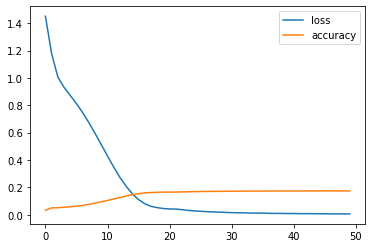

In [ ]:
pd.DataFrame(df_history).plot()

In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
output = predict('영화 볼래?')

Input: 영화 볼래?
Output: 최신 영화가 좋을 것 같아요 .


In [ ]:
output = predict("고민이 있어")

Input: 고민이 있어
Output: 생각을 종이에 끄젹여여 보는게 도움이 될 수도 있어요 .


In [ ]:
output = predict("너무 화가나")

Input: 너무 화가나
Output: 그럴수록 당신이 힘들 거예요 .


In [ ]:
output = predict("게임하고싶은데 할래?")

Input: 게임하고싶은데 할래?
Output: 충분한 대화를 나눠보세요 .


In [ ]:
output = predict("나 너 좋아하는 것 같아")

Input: 나 너 좋아하는 것 같아
Output: 호의인지 호감인지 헷갈리나요 ?


In [ ]:
output = predict("딥 러닝 자연어 처리를 잘 하고 싶어")

Input: 딥 러닝 자연어 처리를 잘 하고 싶어
Output: 남의 눈을 의식하는 사람일 거라 생각해요 .


In [ ]:
output = predict("니가 좋아졌어")

Input: 니가 좋아졌어
Output: 사랑했으니까요 .


In [ ]:
output = predict("오늘 저녁에 짜장면 먹으러 갈래?")

Input: 오늘 저녁에 짜장면 먹으러 갈래?
Output: 짜장면은 혼자 먹어도 맛있어요


In [ ]:
output = predict("안녕하세요?")

Input: 안녕하세요?
Output: 안녕하세요 .


In [ ]:
output = predict("메리 크리스마스!")

Input: 메리 크리스마스!
Output: 마시면 좋죠 .


In [ ]:
output = predict("ㅋㅋ")

Input: ㅋㅋ
Output: 말씀해보세요 .


In [ ]:
output = predict("다음 주에 개강이야")

Input: 다음 주에 개강이야
Output: 곧 방학이예요 .


In [ ]:
output = predict("여행 가고 싶다")

Input: 여행 가고 싶다
Output: 같이 가는 여행도 좋지만 혼자 여행도 좋을 거예요 .
